In [134]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
from utils import * 
import itertools 
from tqdm import tqdm 
import warnings 
import subprocess
import os 
from src.ggkbase import *
from src.files import *  
import glob
import scipy
import matplotlib as mpl 
%load_ext autoreload
%autoreload 2

# NOTE: The MAG annotations in the metadata might be wrong... 
ece_id = 'ece_26_1334'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
# How many total spacers do we have?
genome_id_pattern = r'SR-VP_\d{2}_\d{2}_\d{4}_(ck|N)_(top|bottom|middle)([\.|_])(vamb|metabat2|maxbin2|concoct)([\.|_])(\d+)(_sub)*'
get_genome_id = lambda string : re.search(genome_id_pattern, string).group(0).replace('.', '_')

n = sum([fasta_count_sequences(path) for path in glob.glob('../data/spacers/near_cas/*')])
print('Num. sequences in FASTA files:', n)

Num. sequences in FASTA files: 2043


In [136]:
path = '../data/ggkbase/contigs.fn' # Source of the files for the BLAST database. 

def blast_make_database(path:str, database_path='../data/blast/databases/contigs'):
    # The parse_seqids option basically gets rid of the FASTA description. 
    subprocess.run(f'makeblastdb -in {path} -out {database_path} -dbtype nucl -parse_seqids', shell=True, check=True)

# For the target database, I want to search against all contigs in the vernal pool samples. 
if not os.path.exists(path):
    paths = glob.glob('../data/ggkbase/*contigs.fn')
    cmd = f'cat {' '.join(paths)} > {path}'
    subprocess.run(cmd, shell=True, check=True)
    # sed -i s/id=.*//g contigs.fn To make sure none of the IDs are too long. 

# awk '/^>/ { if (length($0) > 51) print }' contigs.fn

fasta_header_map = dict()
fasta_header_map['Pink_Borg_SR-VP_05_06_2024_N_middle_32_23_complete'] = 'pink_borg_N_middle'
fasta_header_map['Oxblood_Borg_SR-VP_05_06_2024_N_middle_33_15_complete'] = 'oxblood_borg_N_middle'
fasta_header_map['Final_SR-VP_05_06_2024_N_bottom_431kb_linear_phage_62_17_complete'] = 'linear_phage_1_N_bottom'
fasta_header_map['Final_SR-VP_05_06_2024_ck_bottom_654kb_linear_phage_40_18_complete'] = 'linear_phage_1_ck_bottom'
fasta_header_map['Final_SR-VP_05_06_2024_ck_bottom_456kb_linear_phage_52_240_complete'] = 'linear_phage_2_ck_bottom'
fasta_header_map['Final_SR-VP_05_06_2024_ck_bottom_352kb_linear_phage_24_22_complete'] = 'linear_phage_3_ck_bottom'
fasta_header_map['Saturn_mini-Borg_82kb_SR-VP_05_06_2024_N_top_32_38_complete'] = 'saturn_mini_borg_N_top'

# sed -i -E \
# -e 's/^>Pink_Borg_SR-VP_05_06_2024_N_middle_32_23_complete(\b| )/>pink_borg_N_middle\1/' \
# -e 's/^>Oxblood_Borg_SR-VP_05_06_2024_N_middle_33_15_complete(\b| )/>oxblood_borg_N_middle\1/' \
# -e 's/^>Final_SR-VP_05_06_2024_N_bottom_431kb_linear_phage_62_17_complete(\b| )/>linear_phage_1_N_bottom\1/' \
# -e 's/^>Final_SR-VP_05_06_2024_ck_bottom_654kb_linear_phage_40_18_complete(\b| )/>linear_phage_1_ck_bottom\1/' \
# -e 's/^>Final_SR-VP_05_06_2024_ck_bottom_456kb_linear_phage_52_240_complete(\b| )/>linear_phage_2_ck_bottom\1/' \
# -e 's/^>Final_SR-VP_05_06_2024_ck_bottom_352kb_linear_phage_24_22_complete(\b| )/>linear_phage_3_ck_bottom\1/' \
# -e 's/^>Saturn_mini-Borg_82kb_SR-VP_05_06_2024_N_top_32_38_complete(\b| )/>saturn_mini_borg_N_top\1/' \
# input.fasta

# blast_make_database(path)

In [137]:
blast_output_dir = '../data/blast/output'

def run_spacerblast(database_path:str='../data/blast/databases/ece_26_1334', output_dir:str=blast_output_dir, subject_dir:str='../data/spacers/near_cas/'):
    query_extension = '.fa'
    database_name = os.path.basename(database_path)
    for query_path in tqdm(glob.glob(os.path.join(subject_dir, '*')), desc='run_spacerblast: Searching BLAST target database for spacer hits...'):
        output_path = os.path.join(output_dir, f'{database_name}-'+ os.path.basename(query_path).replace(query_extension, '.tsv')) 
        if not os.path.exists(output_path):
            try:
                cmd = f'cctk spacerblast -o {output_path} -d {database_path} -s {query_path}'
                subprocess.run(cmd, shell=True, check=True)
            except:
                print(cmd)
                print(f'run_spacerblast: Spacerblast failed on {query_path}')

run_spacerblast(database_path='../data/blast/databases/contigs', subject_dir='../data/spacers/near_cas/')

run_spacerblast: Searching BLAST target database for spacer hits...: 100%|██████████| 126/126 [00:00<00:00, 170039.35it/s]


In [138]:
# I think it might be OK to include CRISPR spacer matches with two mismatches?
# https://www.nature.com/articles/s42003-020-1014-1 

ece_blast_df = [pd.read_csv(path, sep=r'\s+').assign(query_path=path) for path in glob.glob(f'{blast_output_dir}/ece_26_1334*')]
ece_blast_df = pd.concat(ece_blast_df)
ece_blast_df.columns = ece_blast_df.columns.str.lower()
ece_blast_df = ece_blast_df[ece_blast_df.mismatches <= 1].copy()
# ece_blast_df = ece_blast_df[ece_blast_df.percent_identity > 90].copy()
print('Num. reasonable spacer hits for the ECE:', len(ece_blast_df))

# Several the hits are very short, I wonder if these are the misidentified spacers? In any case, don't really trust them. 


Num. reasonable spacer hits for the ECE: 2


In [139]:
contigs_blast_df = [pd.read_csv(path, sep=r'\s+').assign(query_path=path) for path in glob.glob(f'{blast_output_dir}/contigs*')]
contigs_blast_df = pd.concat(contigs_blast_df)
contigs_blast_df.columns = contigs_blast_df.columns.str.lower()
contigs_blast_df = contigs_blast_df[contigs_blast_df.mismatches <= 1].copy()
print('Num. reasonable spacer hits for the contigs:', len(contigs_blast_df))

Num. reasonable spacer hits for the contigs: 11303


In [140]:
# I think possibly hard to distinguish between self-targeting and organisms having the same spacers. 

min_spacer_length = 25 

contigs_blast_df['host_contig'] = [re.sub(r'_\d+:\d+', '', spacer_id) for spacer_id in contigs_blast_df.spacer_id]
contigs_with_spacers = contigs_blast_df.host_contig.unique()
contigs_blast_df = contigs_blast_df[~contigs_blast_df.target_contig.isin(contigs_with_spacers)].copy()

contigs_blast_df = contigs_blast_df[contigs_blast_df.protospacer_sequence.apply(len) > 25].copy()

remove_target_contigs = ['SR-VP_05_06_2024_N_top_scaffold_173622'] # There is a Cas9 protein on this contig... 
remove_target_contigs += ['SR-VP_05_06_2024_N_top_scaffold_1271'] # Cas protein on this contig too...
remove_target_contigs += ['SR-VP_05_06_2024_ck_bottom_scaffold_1358']

contigs_blast_df = contigs_blast_df[~contigs_blast_df.target_contig.isin(remove_target_contigs)].copy()


In [141]:
metadata_df = load_metadata()
metadata_df = metadata_df[~metadata_df.index.duplicated()].copy()
metadata_df.index = metadata_df.index.str.replace('.', '_', regex=False)

In [142]:
# ECE aligns to the following contigs:
# SR-VP_05_06_2024_N_bottom_scaffold_6272
# SR-VP_05_06_2024_ck_bottom_scaffold_14226
# SR-VP_05_06_2024_N_middle_scaffold_11254
# SR-VP_05_06_2024_N_top_scaffold_11797

# Only put in a bin in ck_bottom and N_middle, which explains why there are only CRISPR array hits in these samples. My target 
# database only contains sequences from non-unknown bins. 

ece_abundance = dict()
ece_abundance['SR-VP_05_06_2024_N_bottom_scaffold_6272'] = 128.92
ece_abundance['SR-VP_05_06_2024_ck_bottom_scaffold_14226'] = 607.23 
ece_abundance['SSR-VP_05_06_2024_N_middle_scaffold_11254'] =  218.23
ece_abundance['SR-VP_05_06_2024_N_top_scaffold_11797'] = 380.62

# Abundances in the environmental samples...
# Coverage units are already normalized, basically a measure of the average number of times each base is sequenced. 
ece_abundance['SR-VP_11_27_2022_S1_40cm_scaffold_15277'] = 1.98
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_16350'] = 4.2
ece_abundance['SR-VP_11_27_2022_S1_40cm_scaffold_14394'] = 2.07
ece_abundance['SR-VP_11_27_2022_S2_40cm_scaffold_19486'] = 3.31
ece_abundance['SR-VP_11_27_2022_S2_40cm_scaffold_25164'] = 3.32
ece_abundance['SR-VP_11_27_2022_S2_40cm_scaffold_32691'] = 1.89
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_26906'] = 6.82
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_81867'] = 2.96
ece_abundance['SR-VP_11_27_2022_S1_40cm_scaffold_100246'] = 1.05
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_131869'] = 4.42
ece_abundance['SR-VP_11_27_2022_S2_40cm_scaffold_140284'] = 2.73
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_209635'] = 4.68
ece_abundance['SR-VP_11_27_2022_S1_100cm_scaffold_2222'] = 9.49

get_metagenome_id = lambda id_ : re.search(r'(S[12]_\d+cm|N_middle|N_top|N_bottom|ck_bottom)', id_).group(0).lower()

def load_organism_info(path:str, ece_abundance:dict=ece_abundance):
    metagenome_id = os.path.basename(path).replace('_organism_info.tsv', '')
    cols = ['id','name','taxonomy','bin length','GC%','coverage', 'curation status','completion status']
    df = pd.read_csv(path, sep='\t', usecols=cols)
    df.columns = [col.lower().replace(' ', '_') if (col != 'GC%') else 'gc_percent' for col in df.columns]
    df['metagenome_id'] = metagenome_id
    df = df[df.coverage > 0].copy()
    df = df.drop(columns=['id']).set_index('name')

    # Add the ECE abundance prior to normalization. 
    for id_, cov in ece_abundance.items():
        if metagenome_id == get_metagenome_id(id_):
            df.loc[id_, ['coverage', 'metagenome_id', 'taxonomy']] = cov, get_metagenome_id(id_), ece_id

    covs = df.coverage.values
    df['normalized_coverage'] = np.log(covs) - np.log(scipy.stats.mstats.gmean(covs))
    # assert df.normalized_coverage.sum() == 0, f'load_organism_info: Expected CLR sum to be zero, got {df.normalized_coverage.sum()}'
    df['taxonomy'] = np.where(df.taxonomy.isnull(), 'none', df.taxonomy)
    return df 

organism_info_df = list()
for path in glob.glob('../data/ggkbase/*organism_info.tsv'):
    organism_info_df.append(load_organism_info(path))

organism_info_df = pd.concat(organism_info_df)
organism_info_df = organism_info_df[organism_info_df.coverage > 0].copy()
# organism_info_df[organism_info_df.taxonomy.str.contains('Archaea')]


In [143]:
for row in organism_info_df.itertuples():
    if row.taxonomy == 'none':
        continue
    if row.taxonomy == ece_id:
        continue
    if ('Bacteria' not in row.taxonomy) and ('Archaea' not in row.taxonomy) and ('Borg' not in row.taxonomy):
        print (row)

In [144]:
organism_info_df[organism_info_df.taxonomy.str.contains('Methanoperedens')]

,taxonomy,bin_length,gc_percent,coverage,curation_status,completion_status,metagenome_id,normalized_coverage
name,,,,,,,,
SR-VP_11_27_2022_S2_40cm_Methanoperedens_44_10,"Candidatus Methanoperedens nitroreducens, Cand...",2998856.0,44.30,10.49,Uncurated genome,near complete,s2_40cm,0.923199
SR-VP_05_06_2024_ck_bottom_Methanoperedens_44_47,Black_host_Methanoperedens_contigs_Illumina_by...,2511192.0,44.03,46.70,Uncurated genome,near complete,ck_bottom,1.384940
SR-VP_05_06_2024_ck_bottom_Methanoperedens_44_24,Black_host_Methanoperedens_contigs_Illumina_by...,1984192.0,44.06,23.86,Uncurated genome,near complete,ck_bottom,0.713399
SR-VP_05_06_2024_N_bottom_Black_host_Methanoperedens_44_7,Black_host_Methanoperedens_contigs_Illumina_by...,2114579.0,43.71,6.66,Uncurated genome,near complete,n_bottom,-0.597356
R-VP_05_06_2024_N_top_Candidatus_Methanoperedens_Black_host-type_44_35,Black_host_Methanoperedens_contigs_Illumina_by...,2502963.0,44.10,35.08,Uncurated genome,near complete,n_top,1.033322
SR-VP_05_06_2024_N_top_Candidatus_Methanoperedens_Black-host_type_44_27,Black_host_Methanoperedens_contigs_Illumina_by...,2425820.0,44.14,27.22,Uncurated genome,near complete,n_top,0.779643
SR-VP_05_06_2024_N_middle_Candidatus_Methanoperedens_presumed_Black_host_44_15,Black_host_Methanoperedens_contigs_Illumina_by...,2401564.0,44.02,15.32,Uncurated genome,near complete,n_middle,0.261656


Num. elements with no assigned domain: 1319


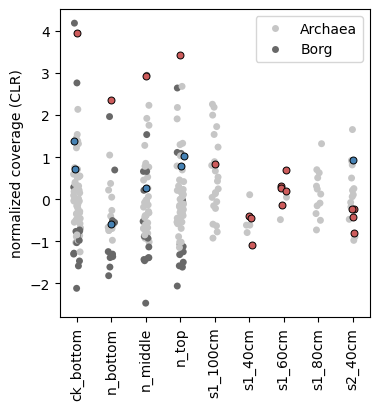

In [145]:
fig, ax = plt.subplots(figsize=(4, 4))

domains = ['Bacteria']
domains = ['Archaea', 'Borg']

figure_df = organism_info_df.copy()
figure_df = figure_df.sort_values('metagenome_id')
figure_df['domain'] = [re.search('Archaea|Bacteria|ece_26_1334|Borg|none', taxonomy).group(0) for taxonomy in figure_df.taxonomy]
print('Num. elements with no assigned domain:', (figure_df.domain != 'none').sum())
figure_df = figure_df[figure_df.domain != 'none'].copy()
figure_df.to_csv('sandbox-3_figure-1.csv')

if domains is not None:
    figure_df = figure_df[figure_df.domain.isin(domains + [ece_id])].copy()

sns.stripplot(figure_df[figure_df.taxonomy != ece_id], x='metagenome_id', y='normalized_coverage', hue='domain', palette='Grays')
sns.stripplot(figure_df[figure_df.taxonomy == ece_id], x='metagenome_id', y='normalized_coverage', color='indianred', linewidth=0.7, edgecolor='black')
sns.stripplot(figure_df[figure_df.taxonomy.str.contains('Methanoperedens')], x='metagenome_id', y='normalized_coverage', color='steelblue', linewidth=0.7, edgecolor='black')
ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('normalized coverage (CLR)')
plt.show()

In [146]:
sample_name_map = {
    'ck_bottom_2025': 'SR-VP_Bioreactor_ck_bot_05_17_2025',
    'ck_middle_2025': 'SR-VP_Bioreactor_ck_mid_05_17_2025',
    'ck_top_2025': 'SR-VP_Bioreactor_ck_top_05_17_2025',
    'n_bottom_2025': 'SR-VP_Bioreactor_N_bot_05_17_2025',
    'n_middle_2025': 'SR-VP_Bioreactor_N_mid_05_17_2025',
    'n_top_2025': 'SR-VP_Bioreactor_N_top_05_17_2025',

    'n_middle_2024': 'SR-VP_05_06_2024_N_middle',
    'n_top_2024':    'SR-VP_05_06_2024_N_top',   
    'n_bottom_2024': 'SR-VP_05_06_2024_N_bottom',
    'ck_bottom_2024': 'SR-VP_05_06_2024_ck_bottom',

    '90cm_2020':  'SR-VP_26_10_2019_1_90cm',
    '100cm_2020': 'SR-VP_26_10_2019_1_100cm',
    '100cm_2021_1': 'SR-VP_26_10_2020_1_100CM',
    '100cm_2021_2': 'SR-VP_26_10_2020_2_100CM',
    '80cm_2023': 'SR-VP_11_27_2022_S1_80cm_MG',
    '40cm_2020': 'SR-VP_26_10_2019_C_40cm',
    '100cm_2022': 'SR-VP_11_27_2022_S1_100cm_MG',
    '90cm_2023': 'SR-VP_07_25_2022_A1_90cm_MG',
    '90cm_2020': 'SR-VP_26_10_2019_2_90cm',
    '60cm_2023': 'SR-VP_11_27_2022_S1_60cm_MG',

    'ck_bottom_2025_metat': 'SR-VP_Bioreactor_ck_bot_05_17_2025_metaT',
    'ck_middle_2025_metat': 'SR-VP_Bioreactor_ck_mid_05_17_2025_metaT',
    'ck_top_2025_metat': 'SR-VP_Bioreactor_ck_top_05_17_2025_metaT',
    'n_top_2025_metat': 'SR-VP_Bioreactor_N_top_05_17_2025_metaT',
    'n_bottom_2025_metat': 'SR-VP_Bioreactor_N_bot_05_17_2025_metaT',
    'n_middle_2025_metat': 'SR-VP_Bioreactor_N_mid_05_17_2025_metaT',

    'ck_bottom_2024_metat': 'SR-VP_Bioreactor_ck_bot_05_06_2024_metaT',
    'n_top_2024_metat': 'SR-VP_Bioreactor_N_top_05_06_2024_metaT',
    'n_bottom_2024_metat': 'SR-VP_Bioreactor_N_bot_05_06_2024_metaT',
    'n_middle_2024_metat': 'SR-VP_Bioreactor_N_mid_05_06_2024_metaT'}


sample_year_map = {
    'SR-VP_26_10_2019_1_90cm': 2020,
    'SR-VP_26_10_2019_1_100cm': 2020,
    'SR-VP_26_10_2020_1_100CM': 2021,
    'SR-VP_26_10_2020_2_100CM': 2021,
    'SR-VP_11_27_2022_S1_80cm_MG': 2023,
    'SR-VP_26_10_2019_C_40cm': 2020,
    'SR-VP_11_27_2022_S1_100cm_MG': 2023,
    'SR-VP_07_25_2022_A1_90cm_MG': 2023,
    'SR-VP_26_10_2019_2_90cm': 2020,
    'SR-VP_11_27_2022_S1_60cm_MG': 2023}

input_path_template = '/groups/banfield/sequences/{year}/{sample_name}/raw.d/{sample_name}_trim_clean.{paired_end}.fastq.gz'

In [147]:
# Apparently the coverage from the metadata is not completely reliable, so need to re-map the reads from the metagenome samples. 

ref_paths = ['../data/ece_26_1334.fn', '../data/methanoperedens_2.fn']
fields = 'mean trimmed_mean covered_bases variance count rpkm tpm'

with open('../scripts/coverm_mapping.sh', 'w') as f:
    for ref_path in ref_paths:
        target_name = os.path.basename(ref_path).replace('.fn', '')
        for name, sample_name in sample_name_map.items():
            if 'metat' in name: # Don't do this for the transcripts. 
                continue 
            paired_ends_1_path = input_path_template.format(paired_end='PE.1', sample_name=sample_name, year=sample_year_map.get(sample_name, 2025))
            paired_ends_2_path = input_path_template.format(paired_end='PE.2', sample_name=sample_name, year=sample_year_map.get(sample_name, 2025))
            output_file_name = f'{name}-{target_name}.tsv'.lower()
            output_path = f'/home/philippar/data/coverm/{output_file_name}'
            cmd = f'coverm contig -1 {paired_ends_1_path} -2 {paired_ends_1_path} -r {ref_path} --min-read-percent-identity 97 --min-read-aligned-percent 80 --trim-min 5 --trim-max 95 -m {fields} -t 20 -o {output_path}'
            f.write(f'sbatch --wrap "{cmd}"\n')

In [148]:
with open('../scripts/bbduk_library_sizes.sh', 'w') as f:
    for name, sample_name in sample_name_map.items():
            paired_ends_1_path = input_path_template.format(paired_end='PE.1', sample_name=sample_name, year=sample_year_map.get(sample_name, 2025))
            paired_ends_2_path = input_path_template.format(paired_end='PE.2', sample_name=sample_name, year=sample_year_map.get(sample_name, 2025))
            output_path = f'/home/philippar/data/bbduk/{name}.txt'
            cmd = f'bbduk.sh in={paired_ends_1_path} in2={paired_ends_2_path} out=/dev/null stats={output_path} threads=64'
            f.write(f'sbatch --wrap "{cmd}"\n')


In [149]:
# length: Length of the contig. 
# variance: Coverage variance, which is a statistical measure of how uneven the read depth is across a contig or genome.
# trimmed_mean: Trimmed mean coverage per contig, which is essentially the mean depth after removing the lowest and highest 10% of per-base coverage values.
#   Read depth is defined per nucleotide base. 
# rpkm: Reads per kb per million mapped reads.
# tpm: TPM-normalized coverage, which is the RPKM for a specific contig divided by the sum of all RPKM. This controls for both contig length and sequencing depth. 

def load_coverm(data_dir='../data/coverm/', cols=fields.split()):
    coverm_df = list()
    for path in glob.glob(os.path.join(data_dir, '*')):
        file_name = os.path.basename(path).replace('.tsv', '')
        sample_name, target_name = file_name.split('-')
        df = pd.read_csv(path, sep='\t', names=cols, skiprows=1)
        df['sample_name'], df['target_name'] = sample_name, target_name
        if len(df) > 0:
            coverm_df.append(df)
    coverm_df = pd.concat(coverm_df)
    return coverm_df

coverm_df = load_coverm()

contig_sizes = fasta_get_contig_sizes('../data/methanoperedens_2.fn')
contig_sizes.update(fasta_get_contig_sizes('../data/ece_26_1334.fn'))
coverm_df['contig_size'] = coverm_df.index.map(contig_sizes)


In [150]:
coverm_df

,mean,trimmed_mean,covered_bases,variance,count,rpkm,tpm,sample_name,target_name,contig_size
19kb_linear_ECE_26_1334,332.337740,337.545720,19030,6262.492700,27150,52521.00800,1000000.000,ck_middle_2025,ece_26_1334,19040
19kb_linear_ECE_26_1334,77.449550,77.978590,19031,502.016200,6186,52521.01000,1000000.000,n_top_2025,ece_26_1334,19040
19kb_linear_ECE_26_1334,279.449220,284.582980,19040,4178.252400,21948,52521.01000,1000000.000,ck_top_2025,ece_26_1334,19040
SR-VP_05_06_2024_ck_bottom_scaffold_1433,19.188807,18.579498,74855,96.110290,5808,480.07864,8053.407,ck_top_2025,methanoperedens_2,74973
SR-VP_05_06_2024_ck_bottom_scaffold_1729,21.652620,21.084372,67022,98.805490,5848,540.73020,9070.848,ck_top_2025,methanoperedens_2,67022
...,...,...,...,...,...,...,...,...,...,...
SR-VP_05_06_2024_ck_bottom_scaffold_889691,0.000000,0.000000,0,0.000000,0,0.00000,0.000,90cm_2023,methanoperedens_2,1240
SR-VP_05_06_2024_ck_bottom_scaffold_975560,0.000000,0.000000,0,0.000000,0,0.00000,0.000,90cm_2023,methanoperedens_2,1178
SR-VP_05_06_2024_ck_bottom_scaffold_1039820,1.722110,1.587838,602,4.523714,8,130.96994,2227.006,90cm_2023,methanoperedens_2,1136
SR-VP_05_06_2024_ck_bottom_scaffold_1075659,0.000000,0.000000,0,0.000000,0,0.00000,0.000,90cm_2023,methanoperedens_2,1114


In [151]:
def load_bbduk(data_dir='../data/bbduk'):
    bbduk_df = list()
    for path in glob.glob(os.path.join(data_dir, '*')):
        with open(path, 'r') as f:
            content = f.read()
        sample_name = os.path.basename(path).replace('.txt', '')
        total = re.search(r'#Total\s+(\d+)', content, flags=re.MULTILINE).group(1)
        bbduk_df.append({'sample_name':sample_name, 'library_size':int(total)})
    return pd.DataFrame(bbduk_df).set_index('sample_name')

bbduk_df = load_bbduk()
bbduk_df = bbduk_df[~bbduk_df.index.str.contains('metat')].copy()
coverm_df['library_size'] = coverm_df.sample_name.map(bbduk_df.library_size)
# RPKM is reads per kilobase of transcript per Million mapped reads
coverm_df['rpkm'] = (coverm_df['count'] / (coverm_df['contig_size'] / 1e3)) / (coverm_df.library_size / 1e6)


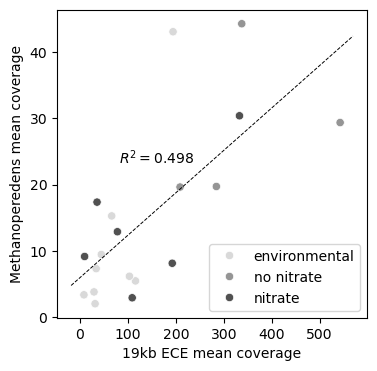

In [153]:

figure_df = coverm_df.groupby(['sample_name', 'target_name']).rpkm.sum().reset_index()
figure_df = figure_df.pivot(columns='target_name', values='rpkm', index='sample_name')
figure_df = coverm_df.groupby(['sample_name', 'target_name']).apply(lambda df : (df['trimmed_mean'] * df.contig_size / df.contig_size.sum()).sum(), include_groups=False)
figure_df = figure_df.reset_index(name='coverage')
figure_df = figure_df.pivot(columns='target_name', values='coverage', index='sample_name')
figure_df['category'] = np.select([figure_df.index.str.match(r'\d+(cm|m)_\d+'), figure_df.index.str.startswith('n_')], ['environmental', 'nitrate'], default='no nitrate')

fig, ax = plt.subplots(figsize=(4, 4), ncols=1)
sns.scatterplot(figure_df, x=ece_id, y='methanoperedens_2', ax=ax, hue='category', palette='Grays')
ax.legend().set_title('')

x, y = figure_df[ece_id].values, figure_df['methanoperedens_2'].values 
r = np.corrcoef(x, y)[0, 1]
m, b = np.polyfit(x, y, 1)

x_min, x_max = ax.get_xlim()
sns.lineplot(x=np.linspace(x_min, x_max, 10), y=np.linspace(x_min, x_max, 10) * m + b, ls='--', color='black', lw=0.7)
ax.text(0.2, 0.5, f'$R^2=$' + f'{r ** 2:.3f}', transform=ax.transAxes)

ax.set_ylabel('Methanoperedens mean coverage')
ax.set_xlabel('19kb ECE mean coverage')

plt.show()


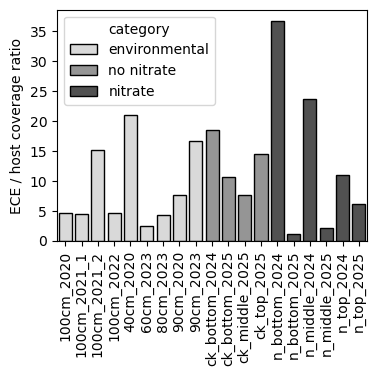

In [158]:
figure_df = coverm_df.groupby(['sample_name', 'target_name']).apply(lambda df : (df['trimmed_mean'] * df.contig_size / df.contig_size.sum()).sum(), include_groups=False)
figure_df = figure_df.reset_index(name='coverage')
figure_df = figure_df.pivot(columns='target_name', values='coverage', index='sample_name')
figure_df['category'] = np.select([figure_df.index.str.match(r'\d+(cm|m)_\d+'), figure_df.index.str.startswith('n_')], ['environmental', 'nitrate'], default='no nitrate')
figure_df['ratio'] = figure_df.ece_26_1334 / figure_df.methanoperedens_2
figure_df['sample_name'] = figure_df.index

# figure_df = figure_df[figure_df.category != 'environmental'].copy()

fig, ax = plt.subplots(figsize=(4, 3), ncols=1)
sns.barplot(figure_df, x='sample_name', y='ratio', ax=ax, hue='category', palette='Grays', edgecolor='black')
# sns.barplot(figure_df, x='sample_name', y='ratio', ax=ax, color='lightgray', edgecolor='black')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('ECE / host coverage ratio')
# ax.legend().set_title('')

plt.show()

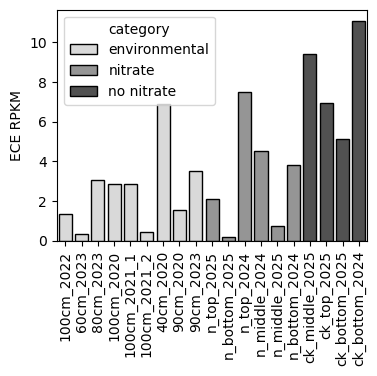

In [160]:
figure_df = coverm_df[coverm_df.target_name == ece_id].copy()
figure_df['category'] = np.select([figure_df.sample_name.str.match(r'\d+(cm|m)_\d+'), figure_df.sample_name.str.startswith('n_')], ['environmental', 'nitrate'], default='no nitrate')

fig, ax = plt.subplots(figsize=(4, 3), ncols=1)
sns.barplot(figure_df.sort_values('category'), x='sample_name', y='rpkm', ax=ax, hue='category', palette='Grays', edgecolor='black')
# sns.barplot(figure_df, x='sample_name', y='ratio', ax=ax, color='lightgray', edgecolor='black')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('ECE RPKM')
# ax.legend().set_title('')

plt.show()

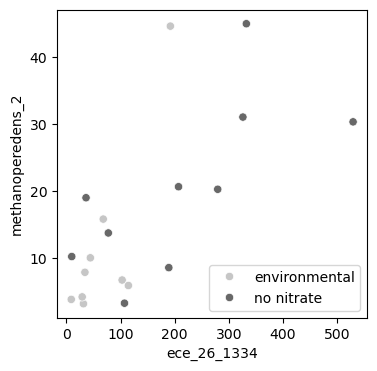

In [155]:
# figure_df = coverm_df.groupby(['sample_name', 'target_name']).rpkm.sum().reset_index()
figure_df = coverm_df.groupby(['sample_name', 'target_name']).apply(lambda df : (df['mean'] * df.contig_size / df.contig_size.sum()).sum(), include_groups=False)
figure_df = figure_df.reset_index(name='coverage')
figure_df = figure_df.pivot(columns='target_name', values='coverage', index='sample_name')
figure_df['category'] = np.select([figure_df.index.str.match(r'\d+(cm|m)_\d+'), figure_df.index.str.startswith('N_')], ['environmental', 'nitrate'], default='no nitrate')
fig, ax = plt.subplots(figsize=(4, 4), ncols=1)
sns.scatterplot(figure_df, x=ece_id, y='methanoperedens_2', ax=ax, hue='category', palette='Grays')
ax.legend().set_title('')
plt.show()

In [156]:
# ece_seq = FASTAFile.from_file(f'../data/{ece_id}.fn').seqs[0]
# ece_df = GenBankFile.from_file(f'../data/{ece_id}.gbk').to_df()

# coordinate_pattern = r'(\d+)..(\d+)'
# ece_df['start'] = [int(re.search(coordinate_pattern, coordinate).group(1)) for coordinate in ece_df.coordinate]
# ece_df['stop'] = [int(re.search(coordinate_pattern, coordinate).group(2)) for coordinate in ece_df.coordinate]
# ece_df['stop_codon'] = [ece_seq[stop - 3:stop] for stop in ece_df.stop]
# ece_df['strand'] = np.where(ece_df.coordinate.str.contains('comp'), '-', '+')

# ece_df['nt_seq'] = [ece_seq[start:stop] for start, stop in zip(ece_df.start, ece_df.stop)]
# ece_df['nt_seq'] = [reverse_complement(row.nt_seq) if (row.strand == '-') else row.nt_seq for row in ece_df.itertuples()] # Reverse complement if on the opposite strand. 

In [157]:
# has_cas = False

# fig, ax = plt.subplots(figsize=(4, 4))

# figure_df = blast_df.copy()
# figure_df = figure_df[figure_df.query_domain != 'none'].copy()
# if has_cas:
#     figure_df = figure_df[figure_df.has_cas].copy()

# sns.ecdfplot(figure_df, x='percent_identity', hue='query_domain', palette='Grays')

# legend = ax.get_legend()
# handles = legend.get_lines()
# labels = [label.get_text() for label in legend.get_texts()][:2]
# # labels = [f'{domain} (n={(figure_df.query_domain == domain).sum()})' for domain in labels]
# labels = [f'{domain} (n={(figure_df.query_domain == domain).sum()})' for domain in labels]
# ax.legend(handles, labels, title='putative host domain')

# ax.set_ylabel('proportion')
# ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter())
# ax.set_xlabel('identity to spacer')

# plt.show()